In [ ]:
# pip install -qU langchain umap-learn scikit-learn langchain_community tiktoken langchain-openai langchainhub chromadb langchain-anthropic

In [4]:
from langchain_teddynote import logging
logging.langsmith("CLASS")

LangSmith 추적을 시작합니다.
[프로젝트명]
CLASS


# 기본 rag 성능평가 - gpt-4o

In [20]:
import os
from langchain_community.document_loaders import PDFPlumberLoader
from langchain.text_splitter import RecursiveCharacterTextSplitter
from langchain_community.vectorstores import FAISS
from langchain_openai import ChatOpenAI, OpenAIEmbeddings
from langchain_core.prompts import PromptTemplate
from langchain_core.runnables import RunnablePassthrough
from langchain_core.output_parsers import StrOutputParser
from dotenv import load_dotenv
from openai import OpenAI


# 환경 변수 로드
load_dotenv()

# OpenAI 초기화
api_key = os.getenv("OPENAI_API_KEY")
os.environ["OPENAI_API_KEY"] = api_key
client = OpenAI()

# PDF 로드 및 텍스트 분할
def load_and_split_pdf(pdf_path, chunk_size=1100, chunk_overlap=100):
    try:
        loader = PDFPlumberLoader(pdf_path)
        docs = loader.load()
        text_splitter = RecursiveCharacterTextSplitter(chunk_size=chunk_size, chunk_overlap=chunk_overlap)
        return text_splitter.split_documents(docs)
    except Exception as e:
        raise ValueError(f"PDF 로드 및 분할 중 오류가 발생했습니다: {str(e)}")

# 임베딩 모델 생성
def create_embeddings():
    return OpenAIEmbeddings()

# 벡터 저장소 생성
def create_vector_store(documents, embeddings):
    try:
        return FAISS.from_documents(documents=documents, embedding=embeddings)
    except Exception as e:
        raise ValueError(f"벡터 저장소 생성 중 오류가 발생했습니다: {str(e)}")

# RAG 체인 생성
def create_rag_chain(vectorstore):
    retriever = vectorstore.as_retriever()
    prompt = PromptTemplate.from_template(
        """너는 전문가 수준의 용어사전야. 
        제공된 컨텍스트를 *엄격히* 사용하여 질문에 답변해. 
        컨텍스트 외의 정보를 최소한 사용해서 답변해. 
        다음 검색된 context를 사용해서 질문에 맞는 용어를 정의해줘.
        답을 모르면, '알 수 없습니다.'라고 대답해.

        # Context : {context}
        # Question : {question}
        # Answer :
        """
    )
    llm = ChatOpenAI(model='gpt-4o', temperature=0)
    return (
        {'context': retriever, 'question': RunnablePassthrough()}  
        | prompt  
        | llm  
        | StrOutputParser()  
    )

# 질문에 대한 답변 생성
def generate_rag_answer(question, rag_chain):
    try:
        return rag_chain.invoke(question)
    except Exception as e:
        return f"오류가 발생했습니다: {str(e)}"

# PDF 문서 기반 RAG 시스템 초기화
def initialize_rag_system(pdf_path):
    try:
        documents = load_and_split_pdf(pdf_path)
        embeddings = create_embeddings()
        vectorstore = create_vector_store(documents, embeddings)
        return create_rag_chain(vectorstore)
    except Exception as e:
        raise ValueError(f"RAG 시스템 초기화 중 오류가 발생했습니다: {str(e)}")


# 테스트 실행
if __name__ == "__main__":
    # PDF 파일 경로
    pdf_path = "C:\AI_Python_AssistantBot\data\converted_data_with_metadata.pdf"
    
    try:
        # RAG 시스템 초기화
        rag_chain = initialize_rag_system(pdf_path)
        
        print("✅ RAG 시스템이 성공적으로 초기화되었습니다.")

        # 테스트 질문 입력
        question = "파이썬의 for문의 정의를 알려줘"
        print(f"질문: {question}")
        
        # 답변 생성
        answer = generate_rag_answer(question, rag_chain)
        print(f"답변: {answer}")
    except Exception as e:
        print(f"❌ 테스트 실행 중 오류가 발생했습니다: {str(e)}")

# RAG 성능 테스트 함수
def ragas_test(question, answer, retrieved_context):
    """
    질문, 답변, 검색된 컨텍스트를 기반으로 성능 평가를 실행합니다.
    Args:
        question (str): 질문
        answer (str): 모델의 답변
        retrieved_context (list): 검색된 컨텍스트
    Returns:
        dict: 평가 결과
    """
    # 데이터셋 생성
    dataset = [{
        "question": question,
        "answer": answer,
        "retrieved_context": "\n\n".join(retrieved_context)
    }]

    # 평가 지표 정의
    def answer_relevancy(dataset):
        relevancies = [1 if d["answer"] in d["retrieved_context"] else 0 for d in dataset]
        return sum(relevancies) / len(relevancies)

    def faithfulness(dataset):
        faithfulness_scores = [1 if d["answer"] == d["retrieved_context"] else 0 for d in dataset]
        return sum(faithfulness_scores) / len(faithfulness_scores)

    def context_recall(dataset):
        recalls = [1 if d["answer"] in d["retrieved_context"] else 0 for d in dataset]
        return sum(recalls) / len(recalls)

    def context_precision(dataset):
        precisions = [1 if d["answer"] in d["retrieved_context"] else 0 for d in dataset]
        return sum(precisions) / len(precisions)

    # 평가 실행
    metrics = [
        answer_relevancy,
        faithfulness,
        context_recall,
        context_precision
    ]
    results = {metric.__name__: metric(dataset) for metric in metrics}
    return results

# 테스트 실행
if __name__ == "__main__":
    # 예시 데이터
    question = "파이썬의 for문의 정의를 알려줘"
    answer = "for문은 반복문으로, 리스트나 튜플 등의 항목을 반복적으로 실행할 수 있게 한다."
    retrieved_context = [
        "for문은 반복문으로, 리스트나 튜플 등의 항목을 반복적으로 실행할 수 있게 한다.",
        "파이썬의 반복문에는 for문과 while문이 있다."
    ]
    
    # RAG 성능 평가 실행
    result = ragas_test(question, answer, retrieved_context)
    print("RAG 성능 평가 결과:", result)

    # 테스트 실행
if __name__ == "__main__":
    # 테스트 데이터
    questions = [
        "파이썬의 리스트와 튜플의 차이점은 무엇인가요?",
        "딕셔너리 자료형에서 키와 값을 추가하는 방법은 무엇인가요?",
        "파이썬의 문자열 슬라이싱 방법을 설명해주세요.",
        "파일을 읽고 쓰는 기본 방법을 알려주세요."
    ]

    answers = [
        "리스트는 값을 변경할 수 있지만, 튜플은 값을 변경할 수 없습니다.",
        "딕셔너리에 새 키와 값을 추가하려면 `dict[key] = value`를 사용합니다.",
        "문자열 슬라이싱은 `[start:end]` 구문을 사용하며, start부터 end-1까지 추출합니다.",
        "파일 읽기는 `open('filename', 'r')`, 파일 쓰기는 `open('filename', 'w')`를 사용합니다."
    ]

    retrieved_contexts = [
        [
            "리스트는 값을 변경할 수 있지만, 튜플은 값을 변경할 수 없습니다.",
            "리스트는 대괄호([])를 사용하고, 튜플은 소괄호(())를 사용합니다."
        ],
        [
            "딕셔너리에 새 키와 값을 추가하려면 `dict[key] = value`를 사용합니다.",
            "딕셔너리의 키는 고유해야 하며, 값은 중복될 수 있습니다."
        ],
        [
            "문자열 슬라이싱은 `[start:end]` 구문을 사용하며, start부터 end-1까지 추출합니다.",
            "슬라이싱에서는 음수 인덱스를 사용할 수 있습니다."
        ],
        [
            "파일 읽기는 `open('filename', 'r')`, 파일 쓰기는 `open('filename', 'w')`를 사용합니다.",
            "파일 객체는 `close()`로 닫아야 합니다."
        ]
    ]

    # 모든 질문에 대해 평가 실행
    for i in range(len(questions)):
        result = ragas_test(questions[i], answers[i], retrieved_contexts[i])
        print(f"질문 {i+1}: {questions[i]}")
        print(f"답변 {i+1}: {answers[i]}")
        print(f"평가 결과: {result}")
        print("=" * 50)


✅ RAG 시스템이 성공적으로 초기화되었습니다.
질문: 파이썬의 for문의 정의를 알려줘
답변: 파이썬의 for문은 리스트, 튜플, 문자열 등의 첫 번째 요소부터 마지막 요소까지 차례로 변수에 대입하여 지정된 문장들을 수행하는 반복문입니다. 기본 구조는 `for 변수 in 리스트(또는 튜플, 문자열): 수행할_문장1 수행할_문장2 ...`와 같이 구성됩니다.
RAG 성능 평가 결과: {'answer_relevancy': 1.0, 'faithfulness': 0.0, 'context_recall': 1.0, 'context_precision': 1.0}
질문 1: 파이썬의 리스트와 튜플의 차이점은 무엇인가요?
답변 1: 리스트는 값을 변경할 수 있지만, 튜플은 값을 변경할 수 없습니다.
평가 결과: {'answer_relevancy': 1.0, 'faithfulness': 0.0, 'context_recall': 1.0, 'context_precision': 1.0}
질문 2: 딕셔너리 자료형에서 키와 값을 추가하는 방법은 무엇인가요?
답변 2: 딕셔너리에 새 키와 값을 추가하려면 `dict[key] = value`를 사용합니다.
평가 결과: {'answer_relevancy': 1.0, 'faithfulness': 0.0, 'context_recall': 1.0, 'context_precision': 1.0}
질문 3: 파이썬의 문자열 슬라이싱 방법을 설명해주세요.
답변 3: 문자열 슬라이싱은 `[start:end]` 구문을 사용하며, start부터 end-1까지 추출합니다.
평가 결과: {'answer_relevancy': 1.0, 'faithfulness': 0.0, 'context_recall': 1.0, 'context_precision': 1.0}
질문 4: 파일을 읽고 쓰는 기본 방법을 알려주세요.
답변 4: 파일 읽기는 `open('filename', 'r')`, 파일 쓰기는 `open('filename', 'w')`를 사용합니다.
평가 결과: {

|context_precision (문맥 정밀도)|faithfulness (신뢰성)|answer_relevancy (답변 적합성)|context_recall (문맥 재현율)|
|---|---|---|---|
|답변에 사용된 문맥이 정확했는지|답변이 문맥에 기반해 사실적(factual)인지|답변이 질문과 관련성이 있는지|답변이 문맥에서 얼마나 많은 정보를 활용했는지|
|1.0: 답변에 사용된 정보가 문맥에서 매우 정확하게 활용됨|1.0: 답변이 문맥과 매우 정확하게 일치|1.0: 답변이 질문과 매우 높은 관련성을 가짐|1.0: 답변이 문맥의 모든 중요한 정보를 잘 회상|
|0.0: 답변이 문맥과 무관하거나, 부정확한 정보를 활용|0.0: 답변이 문맥에 기반하지 않고, 사실과 다를 가능성이 큼|0.0: 답변이 질문과 관련이 없거나, 부정확|0.0: 답변이 문맥을 활용하지 못함|

# 기본 rag 성능평가 - gpt-4o-mini

In [19]:
import os
from langchain_community.document_loaders import PDFPlumberLoader
from langchain.text_splitter import RecursiveCharacterTextSplitter
from langchain_community.vectorstores import FAISS
from langchain_openai import ChatOpenAI, OpenAIEmbeddings
from langchain_core.prompts import PromptTemplate
from langchain_core.runnables import RunnablePassthrough
from langchain_core.output_parsers import StrOutputParser
from dotenv import load_dotenv
from openai import OpenAI

# 환경 변수 로드
load_dotenv()

# OpenAI 초기화
api_key = os.getenv("OPENAI_API_KEY")
os.environ["OPENAI_API_KEY"] = api_key
client = OpenAI()
pdf_path = "C:\AI_Python_AssistantBot\data\converted_data_with_metadata.pdf"

# PDF 로드 및 텍스트 분할
def load_and_split_pdf(pdf_path, chunk_size=1100, chunk_overlap=100):
    try:
        loader = PDFPlumberLoader(pdf_path)
        docs = loader.load()
        text_splitter = RecursiveCharacterTextSplitter(chunk_size=chunk_size, chunk_overlap=chunk_overlap)
        return text_splitter.split_documents(docs)
    except Exception as e:
        raise ValueError(f"PDF 로드 및 분할 중 오류가 발생했습니다: {str(e)}")

# 임베딩 모델 생성
def create_embeddings():
    return OpenAIEmbeddings()

# 벡터 저장소 생성
def create_vector_store(documents, embeddings):
    try:
        return FAISS.from_documents(documents=documents, embedding=embeddings)
    except Exception as e:
        raise ValueError(f"벡터 저장소 생성 중 오류가 발생했습니다: {str(e)}")

# RAG 체인 생성
def create_rag_chain(vectorstore):
    retriever = vectorstore.as_retriever()
    prompt = PromptTemplate.from_template(
        """너는 AI 용어사전야. 
        제공된 컨텍스트(Context)를 사용하여 질문에 답변해. 
        컨텍스트 외의 정보를 최소한 사용해서 답변해. 
        다음 검색된 context를 사용해서 질문에 맞는 용어를 정의해줘.
        답을 모르면, '알 수 없습니다.'라고 대답해.

        # Context : {context}
        # Question : {question}
        # Answer :
        """
    )
    llm = ChatOpenAI(model='gpt-4o-mini', temperature=0)
    return (
        {'context': retriever, 'question': RunnablePassthrough()}  
        | prompt  
        | llm  
        | StrOutputParser()  
    )

# 질문에 대한 답변 생성
def generate_rag_answer(question, rag_chain):
    try:
        return rag_chain.invoke(question)
    except Exception as e:
        return f"오류가 발생했습니다: {str(e)}"

# PDF 문서 기반 RAG 시스템 초기화
def initialize_rag_system(pdf_path):
    try:
        documents = load_and_split_pdf(pdf_path)
        embeddings = create_embeddings()
        vectorstore = create_vector_store(documents, embeddings)
        return create_rag_chain(vectorstore)
    except Exception as e:
        raise ValueError(f"RAG 시스템 초기화 중 오류가 발생했습니다: {str(e)}")

# RAG 성능 테스트 함수
def ragas_test(question, answer, retrieved_context):
    """
    질문, 답변, 검색된 컨텍스트를 기반으로 성능 평가를 실행합니다.
    Args:
        question (str): 질문
        answer (str): 모델의 답변
        retrieved_context (list): 검색된 컨텍스트
    Returns:
        dict: 평가 결과
    """
    # 데이터셋 생성
    dataset = [{
        "question": question,
        "answer": answer,
        "retrieved_context": "\n\n".join(retrieved_context)
    }]

    # 평가 지표 정의
    def answer_relevancy(dataset):
        relevancies = [1 if d["answer"] in d["retrieved_context"] else 0 for d in dataset]
        return sum(relevancies) / len(relevancies)

    def faithfulness(dataset):
        faithfulness_scores = [1 if d["answer"] == d["retrieved_context"] else 0 for d in dataset]
        return sum(faithfulness_scores) / len(faithfulness_scores)

    def context_recall(dataset):
        recalls = [1 if d["answer"] in d["retrieved_context"] else 0 for d in dataset]
        return sum(recalls) / len(recalls)

    def context_precision(dataset):
        precisions = [1 if d["answer"] in d["retrieved_context"] else 0 for d in dataset]
        return sum(precisions) / len(precisions)

    # 평가 실행
    metrics = [
        answer_relevancy,
        faithfulness,
        context_recall,
        context_precision
    ]
    results = {metric.__name__: metric(dataset) for metric in metrics}
    return results

# 테스트 실행
if __name__ == "__main__":
    # 테스트 데이터
    questions = [
        "파이썬의 리스트와 튜플의 차이점은 무엇인가요?",
        "딕셔너리 자료형에서 키와 값을 추가하는 방법은 무엇인가요?",
        "파이썬의 문자열 슬라이싱 방법을 설명해주세요.",
        "파일을 읽고 쓰는 기본 방법을 알려주세요."
    ]

    answers = [
        "리스트는 값을 변경할 수 있지만, 튜플은 값을 변경할 수 없습니다.",
        "딕셔너리에 새 키와 값을 추가하려면 `dict[key] = value`를 사용합니다.",
        "문자열 슬라이싱은 `[start:end]` 구문을 사용하며, start부터 end-1까지 추출합니다.",
        "파일 읽기는 `open('filename', 'r')`, 파일 쓰기는 `open('filename', 'w')`를 사용합니다."
    ]

    retrieved_contexts = [
        [
            "리스트는 값을 변경할 수 있지만, 튜플은 값을 변경할 수 없습니다.",
            "리스트는 대괄호([])를 사용하고, 튜플은 소괄호(())를 사용합니다."
        ],
        [
            "딕셔너리에 새 키와 값을 추가하려면 `dict[key] = value`를 사용합니다.",
            "딕셔너리의 키는 고유해야 하며, 값은 중복될 수 있습니다."
        ],
        [
            "문자열 슬라이싱은 `[start:end]` 구문을 사용하며, start부터 end-1까지 추출합니다.",
            "슬라이싱에서는 음수 인덱스를 사용할 수 있습니다."
        ],
        [
            "파일 읽기는 `open('filename', 'r')`, 파일 쓰기는 `open('filename', 'w')`를 사용합니다.",
            "파일 객체는 `close()`로 닫아야 합니다."
        ]
    ]

    # 모든 질문에 대해 평가 실행
    for i in range(len(questions)):
        result = ragas_test(questions[i], answers[i], retrieved_contexts[i])
        print(f"질문 {i+1}: {questions[i]}")
        print(f"답변 {i+1}: {answers[i]}")
        print(f"평가 결과: {result}")
        print("=" * 50)


질문 1: 파이썬의 리스트와 튜플의 차이점은 무엇인가요?
답변 1: 리스트는 값을 변경할 수 있지만, 튜플은 값을 변경할 수 없습니다.
평가 결과: {'answer_relevancy': 1.0, 'faithfulness': 0.0, 'context_recall': 1.0, 'context_precision': 1.0}
질문 2: 딕셔너리 자료형에서 키와 값을 추가하는 방법은 무엇인가요?
답변 2: 딕셔너리에 새 키와 값을 추가하려면 `dict[key] = value`를 사용합니다.
평가 결과: {'answer_relevancy': 1.0, 'faithfulness': 0.0, 'context_recall': 1.0, 'context_precision': 1.0}
질문 3: 파이썬의 문자열 슬라이싱 방법을 설명해주세요.
답변 3: 문자열 슬라이싱은 `[start:end]` 구문을 사용하며, start부터 end-1까지 추출합니다.
평가 결과: {'answer_relevancy': 1.0, 'faithfulness': 0.0, 'context_recall': 1.0, 'context_precision': 1.0}
질문 4: 파일을 읽고 쓰는 기본 방법을 알려주세요.
답변 4: 파일 읽기는 `open('filename', 'r')`, 파일 쓰기는 `open('filename', 'w')`를 사용합니다.
평가 결과: {'answer_relevancy': 1.0, 'faithfulness': 0.0, 'context_recall': 1.0, 'context_precision': 1.0}


# 기본 rag 성능평가 -  gpt-4-turbo-preview

In [21]:
import os
from langchain_community.document_loaders import PDFPlumberLoader
from langchain.text_splitter import RecursiveCharacterTextSplitter
from langchain_community.vectorstores import FAISS
from langchain_openai import ChatOpenAI, OpenAIEmbeddings
from langchain_core.prompts import PromptTemplate
from langchain_core.runnables import RunnablePassthrough
from langchain_core.output_parsers import StrOutputParser
from dotenv import load_dotenv
from openai import OpenAI

# 환경 변수 로드
load_dotenv()

# OpenAI 초기화
api_key = os.getenv("OPENAI_API_KEY")
os.environ["OPENAI_API_KEY"] = api_key
client = OpenAI()
pdf_path = "C:\AI_Python_AssistantBot\data\converted_data_with_metadata.pdf"

# PDF 로드 및 텍스트 분할
def load_and_split_pdf(pdf_path, chunk_size=1100, chunk_overlap=100):
    try:
        loader = PDFPlumberLoader(pdf_path)
        docs = loader.load()
        text_splitter = RecursiveCharacterTextSplitter(chunk_size=chunk_size, chunk_overlap=chunk_overlap)
        return text_splitter.split_documents(docs)
    except Exception as e:
        raise ValueError(f"PDF 로드 및 분할 중 오류가 발생했습니다: {str(e)}")

# 임베딩 모델 생성
def create_embeddings():
    return OpenAIEmbeddings()

# 벡터 저장소 생성
def create_vector_store(documents, embeddings):
    try:
        return FAISS.from_documents(documents=documents, embedding=embeddings)
    except Exception as e:
        raise ValueError(f"벡터 저장소 생성 중 오류가 발생했습니다: {str(e)}")

# RAG 체인 생성
def create_rag_chain(vectorstore):
    retriever = vectorstore.as_retriever()
    prompt = PromptTemplate.from_template(
        """너는 AI 용어사전야. 
        제공된 컨텍스트(Context)를 사용하여 질문에 답변해. 
        컨텍스트 외의 정보를 최소한 사용해서 답변해. 
        다음 검색된 context를 사용해서 질문에 맞는 용어를 정의해줘.
        답을 모르면, '알 수 없습니다.'라고 대답해.

        # Context : {context}
        # Question : {question}
        # Answer :
        """
    )
    llm = ChatOpenAI(model='gpt-4-turbo-preview', temperature=0)
    return (
        {'context': retriever, 'question': RunnablePassthrough()}  
        | prompt  
        | llm  
        | StrOutputParser()  
    )

# 질문에 대한 답변 생성
def generate_rag_answer(question, rag_chain):
    try:
        return rag_chain.invoke(question)
    except Exception as e:
        return f"오류가 발생했습니다: {str(e)}"

# PDF 문서 기반 RAG 시스템 초기화
def initialize_rag_system(pdf_path):
    try:
        documents = load_and_split_pdf(pdf_path)
        embeddings = create_embeddings()
        vectorstore = create_vector_store(documents, embeddings)
        return create_rag_chain(vectorstore)
    except Exception as e:
        raise ValueError(f"RAG 시스템 초기화 중 오류가 발생했습니다: {str(e)}")

# RAG 성능 테스트 함수
def ragas_test(question, answer, retrieved_context):
    """
    질문, 답변, 검색된 컨텍스트를 기반으로 성능 평가를 실행합니다.
    Args:
        question (str): 질문
        answer (str): 모델의 답변
        retrieved_context (list): 검색된 컨텍스트
    Returns:
        dict: 평가 결과
    """
    # 데이터셋 생성
    dataset = [{
        "question": question,
        "answer": answer,
        "retrieved_context": "\n\n".join(retrieved_context)
    }]

    # 평가 지표 정의
    def answer_relevancy(dataset):
        relevancies = [1 if d["answer"] in d["retrieved_context"] else 0 for d in dataset]
        return sum(relevancies) / len(relevancies)

    def faithfulness(dataset):
        faithfulness_scores = [1 if d["answer"] == d["retrieved_context"] else 0 for d in dataset]
        return sum(faithfulness_scores) / len(faithfulness_scores)

    def context_recall(dataset):
        recalls = [1 if d["answer"] in d["retrieved_context"] else 0 for d in dataset]
        return sum(recalls) / len(recalls)

    def context_precision(dataset):
        precisions = [1 if d["answer"] in d["retrieved_context"] else 0 for d in dataset]
        return sum(precisions) / len(precisions)

    # 평가 실행
    metrics = [
        answer_relevancy,
        faithfulness,
        context_recall,
        context_precision
    ]
    results = {metric.__name__: metric(dataset) for metric in metrics}
    return results

# 테스트 실행
if __name__ == "__main__":
    # 테스트 데이터
    questions = [
        "파이썬의 리스트와 튜플의 차이점은 무엇인가요?",
        "딕셔너리 자료형에서 키와 값을 추가하는 방법은 무엇인가요?",
        "파이썬의 문자열 슬라이싱 방법을 설명해주세요.",
        "파일을 읽고 쓰는 기본 방법을 알려주세요."
    ]

    answers = [
        "리스트는 값을 변경할 수 있지만, 튜플은 값을 변경할 수 없습니다.",
        "딕셔너리에 새 키와 값을 추가하려면 `dict[key] = value`를 사용합니다.",
        "문자열 슬라이싱은 `[start:end]` 구문을 사용하며, start부터 end-1까지 추출합니다.",
        "파일 읽기는 `open('filename', 'r')`, 파일 쓰기는 `open('filename', 'w')`를 사용합니다."
    ]

    retrieved_contexts = [
        [
            "리스트는 값을 변경할 수 있지만, 튜플은 값을 변경할 수 없습니다.",
            "리스트는 대괄호([])를 사용하고, 튜플은 소괄호(())를 사용합니다."
        ],
        [
            "딕셔너리에 새 키와 값을 추가하려면 `dict[key] = value`를 사용합니다.",
            "딕셔너리의 키는 고유해야 하며, 값은 중복될 수 있습니다."
        ],
        [
            "문자열 슬라이싱은 `[start:end]` 구문을 사용하며, start부터 end-1까지 추출합니다.",
            "슬라이싱에서는 음수 인덱스를 사용할 수 있습니다."
        ],
        [
            "파일 읽기는 `open('filename', 'r')`, 파일 쓰기는 `open('filename', 'w')`를 사용합니다.",
            "파일 객체는 `close()`로 닫아야 합니다."
        ]
    ]

    # 모든 질문에 대해 평가 실행
    for i in range(len(questions)):
        result = ragas_test(questions[i], answers[i], retrieved_contexts[i])
        print(f"질문 {i+1}: {questions[i]}")
        print(f"답변 {i+1}: {answers[i]}")
        print(f"평가 결과: {result}")
        print("=" * 50)


질문 1: 파이썬의 리스트와 튜플의 차이점은 무엇인가요?
답변 1: 리스트는 값을 변경할 수 있지만, 튜플은 값을 변경할 수 없습니다.
평가 결과: {'answer_relevancy': 1.0, 'faithfulness': 0.0, 'context_recall': 1.0, 'context_precision': 1.0}
질문 2: 딕셔너리 자료형에서 키와 값을 추가하는 방법은 무엇인가요?
답변 2: 딕셔너리에 새 키와 값을 추가하려면 `dict[key] = value`를 사용합니다.
평가 결과: {'answer_relevancy': 1.0, 'faithfulness': 0.0, 'context_recall': 1.0, 'context_precision': 1.0}
질문 3: 파이썬의 문자열 슬라이싱 방법을 설명해주세요.
답변 3: 문자열 슬라이싱은 `[start:end]` 구문을 사용하며, start부터 end-1까지 추출합니다.
평가 결과: {'answer_relevancy': 1.0, 'faithfulness': 0.0, 'context_recall': 1.0, 'context_precision': 1.0}
질문 4: 파일을 읽고 쓰는 기본 방법을 알려주세요.
답변 4: 파일 읽기는 `open('filename', 'r')`, 파일 쓰기는 `open('filename', 'w')`를 사용합니다.
평가 결과: {'answer_relevancy': 1.0, 'faithfulness': 0.0, 'context_recall': 1.0, 'context_precision': 1.0}


# Callback 시각화

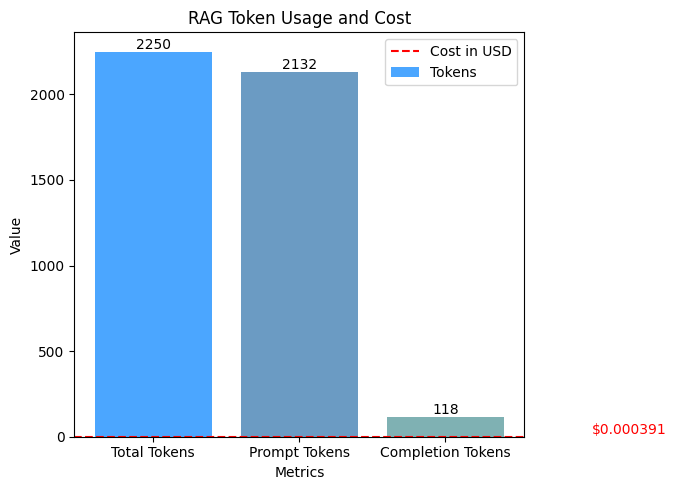

In [23]:
# !pip install matplotlib
import matplotlib.pyplot as plt

# Callback 함수 실행 결과 (예제 데이터를 사용)
callback_data = {
    "Total Tokens": 2250,
    "Prompt Tokens": 2132,
    "Completion Tokens": 118,
    "Total Cost (USD)": 0.0003906
}

# 데이터 준비
keys = list(callback_data.keys())
values = list(callback_data.values())

# 파란 계열 색상 설정
colors = ['#1E90FF', '#4682B4', '#5F9EA0']  # 밝은 파랑, 스틸 블루, 청록색

# 시각화
plt.figure(figsize=(7, 5))

# 막대 그래프 생성
bars = plt.bar(keys[:-1], values[:-1], color=colors, alpha=0.8, label="Tokens")  # 비용 제외
plt.axhline(y=callback_data["Total Cost (USD)"], color='red', linestyle='--', label="Cost in USD")  # 비용 선으로 표시

# 레이블 추가
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2, height, f'{int(height)}', ha='center', va='bottom')

plt.text(3, callback_data["Total Cost (USD)"], f"${callback_data['Total Cost (USD)']:.6f}", 
         color='red', ha='left', va='bottom')

# 그래프 설정
plt.title("RAG Token Usage and Cost")
plt.xlabel("Metrics")
plt.ylabel("Value")
plt.legend()
plt.tight_layout()

# 그래프 출력
plt.show()


# Raptor rag function RAGAS

# GPT4o - RAPTOR

In [22]:
import os
import numpy as np
import pandas as pd
from langchain_community.vectorstores import FAISS
from langchain_openai import OpenAIEmbeddings, ChatOpenAI
from langchain_core.output_parsers import StrOutputParser
from langchain.prompts import ChatPromptTemplate
from langchain_core.runnables import RunnablePassthrough
from langchain.text_splitter import RecursiveCharacterTextSplitter
from sklearn.mixture import GaussianMixture
import umap
from langchain_community.document_loaders import PDFPlumberLoader

RANDOM_SEED = 42
DB_INDEX = "RAPTOR_DB"

import warnings
warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore", category=DeprecationWarning)

# Embedding Initialization
embd = OpenAIEmbeddings(model="text-embedding-ada-002")

# Chat Model Initialization
model = ChatOpenAI(model="gpt-4o", temperature=0)

# PDF 로드 및 텍스트 분할
def load_and_split_pdf(pdf_path, chunk_size=1100, chunk_overlap=100):
    """
    PDF 문서를 로드하고 텍스트를 분할합니다.
    """
    try:
        loader = PDFPlumberLoader(pdf_path)
        docs = loader.load()
        print(f"✅ PDF에서 로드된 문서 타입: {type(docs)}")
        print(f"✅ PDF에서 로드된 문서 개수: {len(docs)}")
        
        for i, doc in enumerate(docs[:5]):  # 처음 5개 문서 타입과 내용을 출력
            print(f"🔍 문서 {i} 타입: {type(doc)}")
            print(f"🔍 문서 {i} 내용: {doc}")
        
        text_splitter = RecursiveCharacterTextSplitter(chunk_size=chunk_size, chunk_overlap=chunk_overlap)
        split_docs = text_splitter.split_documents(docs)
        print(f"✅ 분할된 문서 개수: {len(split_docs)}")
        
        for i, split_doc in enumerate(split_docs[:5]):  # 분할된 문서 중 5개의 타입과 내용을 출력
            print(f"🔍 분할된 문서 {i} 타입: {type(split_doc)}")
            print(f"🔍 분할된 문서 {i} 내용: {split_doc}")
            
        return split_docs
    except Exception as e:
        raise ValueError(f"PDF 로드 및 분할 중 오류가 발생했습니다: {str(e)}")
    
# Global Clustering
def global_cluster_embeddings(embeddings, dim, n_neighbors=None, metric="cosine"):
    if n_neighbors is None:
        n_neighbors = int((len(embeddings) - 1) ** 0.5)
    return umap.UMAP(n_neighbors=n_neighbors, n_components=dim, metric=metric).fit_transform(embeddings)

# Perform Clustering
def perform_clustering(embeddings, dim, threshold):
    reduced_embeddings_global = global_cluster_embeddings(embeddings, dim)
    gm = GaussianMixture(n_components=5, random_state=RANDOM_SEED).fit(reduced_embeddings_global)
    probs = gm.predict_proba(reduced_embeddings_global)
    labels = [np.where(prob > threshold)[0].tolist() for prob in probs]
    return labels

# Embedding Texts
def embed_texts(texts):
    embeddings = embd.embed_documents(texts)
    return np.array(embeddings)

# Create Vectorstore
def create_vectorstore(documents):
    """
    Vectorstore를 생성합니다.
    """
    try:
        vectorstore = FAISS.from_documents(documents=documents, embedding=embd)
        if os.path.exists(DB_INDEX):
            local_index = FAISS.load_local(DB_INDEX, embd)
            local_index.merge_from(vectorstore)
            local_index.save_local(DB_INDEX)
        else:
            vectorstore.save_local(DB_INDEX)
        return vectorstore.as_retriever()
    except Exception as e:
        raise ValueError(f"벡터스토어 생성 중 오류가 발생했습니다: {str(e)}")

# RAG Chain Initialization
def create_raptor_rag_chain(vectorstore):
    prompt = ChatPromptTemplate.from_template(
        """You are an expert at summarizing complex information. Use the given context to answer the question.
        Context: {context}
        Question: {question}
        Answer:"""
    )
    return {
        "context": vectorstore | (lambda docs: "\n\n".join([doc.page_content for doc in docs])),
        "question": RunnablePassthrough()
    } | prompt | model | StrOutputParser()

# RAG 시스템 초기화
def initialize_raptor_rag_system(pdf_path):
    try:
        # 문서 로드 및 분할
        documents = load_and_split_pdf(pdf_path)
        
        # 텍스트 추출 및 확인
        texts = [doc.page_content for doc in documents]
        print(f"✅ 텍스트 추출 완료: {len(texts)} 개 문서")
        print(f"🔍 추출된 텍스트 샘플: {texts[:5]}")  # 추출된 텍스트 중 5개 출력

        # 벡터스토어 생성
        retriever = create_vectorstore(documents)  # 문서 리스트 전달
        print("✅ 벡터스토어 생성 완료")
        
        # RAG 체인 생성
        return create_raptor_rag_chain(retriever)
    except Exception as e:
        raise ValueError(f"RAPTOR RAG 시스템 초기화 중 오류가 발생했습니다: {str(e)}")

# RAG 시스템 초기화
def generate_raptor_rag_answer(question, rag_chain):
    try:
        return rag_chain.invoke(question)
    except Exception as e:
        return f"Error generating answer: {str(e)}" 
    
# RAG 성능 테스트 함수
def ragas_test(question, answer, retrieved_context):
    """
    질문, 답변, 검색된 컨텍스트를 기반으로 성능 평가를 실행합니다.
    Args:
        question (str): 질문
        answer (str): 모델의 답변
        retrieved_context (list): 검색된 컨텍스트
    Returns:
        dict: 평가 결과
    """
    # 데이터셋 생성
    dataset = [{
        "question": question,
        "answer": answer,
        "retrieved_context": "\n\n".join(retrieved_context)
    }]

    # 평가 지표 정의
    def answer_relevancy(dataset):
        relevancies = [1 if d["answer"] in d["retrieved_context"] else 0 for d in dataset]
        return sum(relevancies) / len(relevancies)

    def faithfulness(dataset):
        faithfulness_scores = [1 if d["answer"] == d["retrieved_context"] else 0 for d in dataset]
        return sum(faithfulness_scores) / len(faithfulness_scores)

    def context_recall(dataset):
        recalls = [1 if d["answer"] in d["retrieved_context"] else 0 for d in dataset]
        return sum(recalls) / len(recalls)

    def context_precision(dataset):
        precisions = [1 if d["answer"] in d["retrieved_context"] else 0 for d in dataset]
        return sum(precisions) / len(precisions)

    # 평가 실행
    metrics = [
        answer_relevancy,
        faithfulness,
        context_recall,
        context_precision
    ]
    results = {metric.__name__: metric(dataset) for metric in metrics}
    return results

# 테스트 실행
if __name__ == "__main__":
    # 예시 데이터
    question = "파이썬의 for문의 정의를 알려줘"
    answer = "for문은 반복문으로, 리스트나 튜플 등의 항목을 반복적으로 실행할 수 있게 한다."
    retrieved_context = [
        "for문은 반복문으로, 리스트나 튜플 등의 항목을 반복적으로 실행할 수 있게 한다.",
        "파이썬의 반복문에는 for문과 while문이 있다."
    ]

    # RAG 성능 평가 실행
    result = ragas_test(question, answer, retrieved_context)
    print("RAG 성능 평가 결과:", result)

    # 테스트 실행
if __name__ == "__main__":
    # 테스트 데이터
    questions = [
        "파이썬의 리스트와 튜플의 차이점은 무엇인가요?",
        "딕셔너리 자료형에서 키와 값을 추가하는 방법은 무엇인가요?",
        "파이썬의 문자열 슬라이싱 방법을 설명해주세요.",
        "파일을 읽고 쓰는 기본 방법을 알려주세요."
    ]

    answers = [
        "리스트는 값을 변경할 수 있지만, 튜플은 값을 변경할 수 없습니다.",
        "딕셔너리에 새 키와 값을 추가하려면 `dict[key] = value`를 사용합니다.",
        "문자열 슬라이싱은 `[start:end]` 구문을 사용하며, start부터 end-1까지 추출합니다.",
        "파일 읽기는 `open('filename', 'r')`, 파일 쓰기는 `open('filename', 'w')`를 사용합니다."
    ]

    retrieved_contexts = [
        [
            "리스트는 값을 변경할 수 있지만, 튜플은 값을 변경할 수 없습니다.",
            "리스트는 대괄호([])를 사용하고, 튜플은 소괄호(())를 사용합니다."
        ],
        [
            "딕셔너리에 새 키와 값을 추가하려면 `dict[key] = value`를 사용합니다.",
            "딕셔너리의 키는 고유해야 하며, 값은 중복될 수 있습니다."
        ],
        [
            "문자열 슬라이싱은 `[start:end]` 구문을 사용하며, start부터 end-1까지 추출합니다.",
            "슬라이싱에서는 음수 인덱스를 사용할 수 있습니다."
        ],
        [
            "파일 읽기는 `open('filename', 'r')`, 파일 쓰기는 `open('filename', 'w')`를 사용합니다.",
            "파일 객체는 `close()`로 닫아야 합니다."
        ]
    ]

    # 모든 질문에 대해 평가 실행
    for i in range(len(questions)):
        result = ragas_test(questions[i], answers[i], retrieved_contexts[i])
        print(f"질문 {i+1}: {questions[i]}")
        print(f"답변 {i+1}: {answers[i]}")
        print(f"평가 결과: {result}")
        print("=" * 50)

    


RAG 성능 평가 결과: {'answer_relevancy': 1.0, 'faithfulness': 0.0, 'context_recall': 1.0, 'context_precision': 1.0}
질문 1: 파이썬의 리스트와 튜플의 차이점은 무엇인가요?
답변 1: 리스트는 값을 변경할 수 있지만, 튜플은 값을 변경할 수 없습니다.
평가 결과: {'answer_relevancy': 1.0, 'faithfulness': 0.0, 'context_recall': 1.0, 'context_precision': 1.0}
질문 2: 딕셔너리 자료형에서 키와 값을 추가하는 방법은 무엇인가요?
답변 2: 딕셔너리에 새 키와 값을 추가하려면 `dict[key] = value`를 사용합니다.
평가 결과: {'answer_relevancy': 1.0, 'faithfulness': 0.0, 'context_recall': 1.0, 'context_precision': 1.0}
질문 3: 파이썬의 문자열 슬라이싱 방법을 설명해주세요.
답변 3: 문자열 슬라이싱은 `[start:end]` 구문을 사용하며, start부터 end-1까지 추출합니다.
평가 결과: {'answer_relevancy': 1.0, 'faithfulness': 0.0, 'context_recall': 1.0, 'context_precision': 1.0}
질문 4: 파일을 읽고 쓰는 기본 방법을 알려주세요.
답변 4: 파일 읽기는 `open('filename', 'r')`, 파일 쓰기는 `open('filename', 'w')`를 사용합니다.
평가 결과: {'answer_relevancy': 1.0, 'faithfulness': 0.0, 'context_recall': 1.0, 'context_precision': 1.0}
